# NB03: Retrospective Validation — Ecotype Species Screening

**Run on**: Local machine

## Goal

Test **H2**: Does branch distance CV outperform the ANI-based proxy used in `ecotype_analysis` for predicting which species show significant environment–gene content correlation?

The prior project (`ecotype_analysis/data/ecotype_correlation_results.csv`) contains 213 species with Jaccard-based correlation scores (`r_ani_jaccard`, `r_emb_jaccard`). We link these to our new branch-distance CV scores for the 213 species that overlap with the 338-species tree universe.

## Columns from prior analysis

| Column | Description |
|--------|-------------|
| `r_ani_jaccard` | Mantel-like correlation between ANI distance and gene content Jaccard distance |
| `r_emb_jaccard` | Correlation between AlphaEarth embedding distance and gene content Jaccard |
| `r_partial_emb_jaccard` | Partial correlation (env | phylo) — the key ecotype signal |
| `p_partial_emb` | p-value for partial correlation |

## H2 Test

For species in both datasets: does `cv_branch_dist` (new) better predict `r_partial_emb_jaccard` (prior ecotype signal) than `r_ani_jaccard` (old phylo proxy)?

We also test whether composite score predicts prior ecotype signal strength.

In [1]:
# Cell 1: Imports and load data

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

DATA_PATH = "../data"
FIG_PATH = "../figures"

scored = pd.read_csv(f"{DATA_PATH}/species_scored.csv")
prior = pd.read_csv("../../ecotype_analysis/data/ecotype_correlation_results.csv")

print(f"Scored species: {len(scored)}")
print(f"Prior ecotype_analysis species: {len(prior)}")
print(f"\nPrior columns: {prior.columns.tolist()}")
print(f"\nPrior data types and null counts:")
print(prior.dtypes)
print(prior.isna().sum())

Scored species: 338
Prior ecotype_analysis species: 213

Prior columns: ['species', 'short_name', 'n_genomes', 'r_emb_jaccard', 'r_ani_jaccard', 'r_partial_emb_jaccard', 'p_partial_emb']

Prior data types and null counts:
species                      str
short_name                   str
n_genomes                  int64
r_emb_jaccard            float64
r_ani_jaccard            float64
r_partial_emb_jaccard    float64
p_partial_emb            float64
dtype: object
species                   0
short_name                0
n_genomes                 0
r_emb_jaccard            30
r_ani_jaccard             0
r_partial_emb_jaccard    30
p_partial_emb            30
dtype: int64


In [2]:
# Cell 2: Merge scored species with prior results

overlap = scored.merge(
    prior.rename(columns={'species': 'gtdb_species_clade_id'}).drop(columns=['short_name', 'n_genomes'], errors='ignore'),
    on='gtdb_species_clade_id',
    how='inner'
)

print(f"Species in both datasets: {len(overlap)}")
print(f"  With r_partial_emb_jaccard: {overlap['r_partial_emb_jaccard'].notna().sum()}")
print(f"  With r_ani_jaccard: {overlap['r_ani_jaccard'].notna().sum()}")
print(f"  With r_emb_jaccard: {overlap['r_emb_jaccard'].notna().sum()}")

h2_df = overlap.dropna(subset=['cv_branch_dist', 'r_ani_jaccard'])
print(f"\nUsable for H2 comparison (cv + r_ani_jaccard): {len(h2_df)}")

h2_partial = overlap.dropna(subset=['cv_branch_dist', 'r_partial_emb_jaccard'])
print(f"Usable for partial correlation comparison: {len(h2_partial)}")


Species in both datasets: 99
  With r_partial_emb_jaccard: 85
  With r_ani_jaccard: 99
  With r_emb_jaccard: 85

Usable for H2 comparison (cv + r_ani_jaccard): 99
Usable for partial correlation comparison: 85


In [3]:
# Cell 3: H2 — Does branch distance CV predict prior ANI-Jaccard correlation?
#
# r_ani_jaccard measures how strongly phylogenetic distance (ANI proxy)
# correlates with gene content distance. High values mean phylogeny
# explains gene content well — a prerequisite for ecotype signal.

# Correlation: cv_branch_dist vs r_ani_jaccard
r_cv_ani, p_cv_ani = stats.spearmanr(
    h2_df['cv_branch_dist'], h2_df['r_ani_jaccard'], nan_policy='omit'
)

print("H2: Does branch distance CV correlate with prior ANI-Jaccard correlation?")
print(f"  N = {len(h2_df)}")
print(f"  Spearman rho (CV vs r_ani_jaccard) = {r_cv_ani:.3f}  (p = {p_cv_ani:.4f})")

# Compare: does the composite score do better?
if len(h2_partial) > 5:
    r_comp_partial, p_comp_partial = stats.spearmanr(
        h2_partial['composite_score'], h2_partial['r_partial_emb_jaccard'], nan_policy='omit'
    )
    print(f"\n  Spearman rho (composite_score vs r_partial_emb_jaccard) = {r_comp_partial:.3f}  (p = {p_comp_partial:.4f})")
    print(f"  N = {len(h2_partial)}")

if p_cv_ani < 0.05:
    print(f"\n  -> Significant correlation. Branch distance CV predicts prior ecotype signal.")
else:
    print(f"\n  -> No significant correlation. H2 not supported — note sparse partial correlation coverage in prior data.")

H2: Does branch distance CV correlate with prior ANI-Jaccard correlation?
  N = 99
  Spearman rho (CV vs r_ani_jaccard) = 0.153  (p = 0.1299)

  Spearman rho (composite_score vs r_partial_emb_jaccard) = 0.277  (p = 0.0103)
  N = 85

  -> No significant correlation. H2 not supported — note sparse partial correlation coverage in prior data.


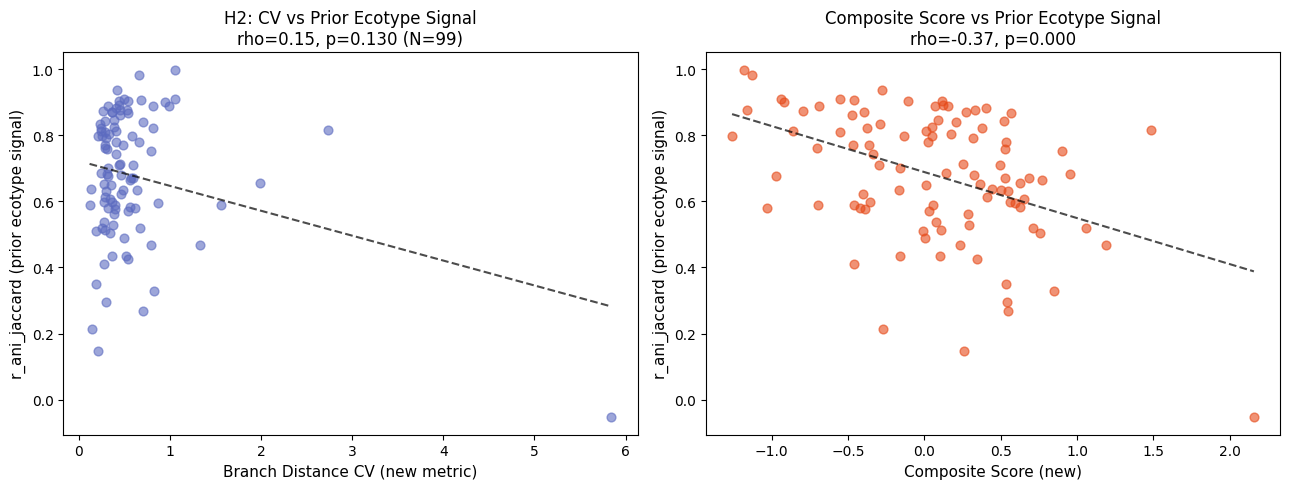

Saved h2_retrospective_validation.png


In [4]:
# Cell 4: Visualize H2 — CV vs r_ani_jaccard scatter

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Panel A: CV vs r_ani_jaccard
ax = axes[0]
ax.scatter(h2_df['cv_branch_dist'], h2_df['r_ani_jaccard'], alpha=0.6, s=40, color='#5C6BC0')
m, b = np.polyfit(h2_df['cv_branch_dist'].dropna(), h2_df['r_ani_jaccard'].dropna(), 1)
x_line = np.linspace(h2_df['cv_branch_dist'].min(), h2_df['cv_branch_dist'].max(), 100)
ax.plot(x_line, m * x_line + b, 'k--', linewidth=1.5, alpha=0.7)
ax.set_xlabel('Branch Distance CV (new metric)', fontsize=11)
ax.set_ylabel('r_ani_jaccard (prior ecotype signal)', fontsize=11)
ax.set_title(f'H2: CV vs Prior Ecotype Signal\nrho={r_cv_ani:.2f}, p={p_cv_ani:.3f} (N={len(h2_df)})')

# Panel B: Composite score vs r_ani_jaccard
ax = axes[1]
ax.scatter(h2_df['composite_score'], h2_df['r_ani_jaccard'], alpha=0.6, s=40, color='#E64A19')
if len(h2_df) > 3:
    r_c, p_c = stats.spearmanr(h2_df['composite_score'], h2_df['r_ani_jaccard'], nan_policy='omit')
    m2, b2 = np.polyfit(h2_df['composite_score'], h2_df['r_ani_jaccard'], 1)
    x2 = np.linspace(h2_df['composite_score'].min(), h2_df['composite_score'].max(), 100)
    ax.plot(x2, m2 * x2 + b2, 'k--', linewidth=1.5, alpha=0.7)
    ax.set_title(f'Composite Score vs Prior Ecotype Signal\nrho={r_c:.2f}, p={p_c:.3f}')
ax.set_xlabel('Composite Score (new)', fontsize=11)
ax.set_ylabel('r_ani_jaccard (prior ecotype signal)', fontsize=11)

plt.tight_layout()
plt.savefig(f"{FIG_PATH}/h2_retrospective_validation.png", dpi=150, bbox_inches='tight')
plt.show()
print("Saved h2_retrospective_validation.png")

N for composite vs r_partial: 85
Spearman rho (composite vs r_partial_emb_jaccard) = 0.277, p = 0.0103


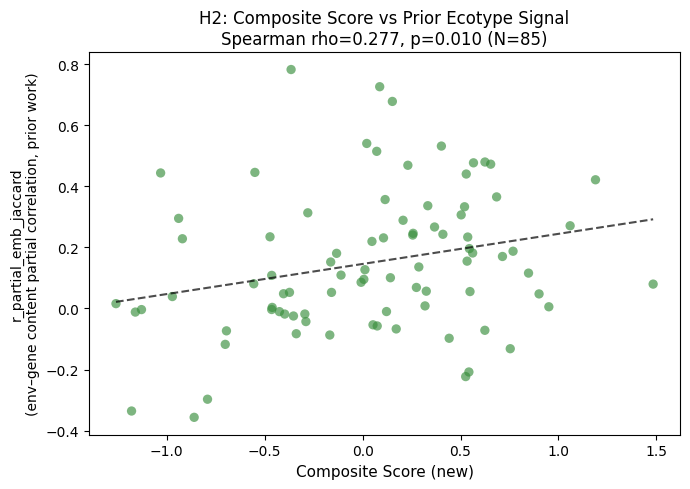

Saved h2_composite_vs_rpartial.png


In [5]:
# Cell 4b: Visualize the key H2 metric — composite score vs r_partial_emb_jaccard
#
# This is the most relevant validation: does the composite score predict the
# environment–gene content partial correlation (controlling for phylogeny)?
# That partial correlation is the core ecotype signal from prior work.

h2_partial = overlap.dropna(subset=['composite_score', 'r_partial_emb_jaccard'])
print(f"N for composite vs r_partial: {len(h2_partial)}")

rho_partial, p_partial = stats.spearmanr(
    h2_partial['composite_score'], h2_partial['r_partial_emb_jaccard']
)
print(f"Spearman rho (composite vs r_partial_emb_jaccard) = {rho_partial:.3f}, p = {p_partial:.4f}")

fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(h2_partial['composite_score'], h2_partial['r_partial_emb_jaccard'],
           alpha=0.65, s=45, color='#388E3C', edgecolors='none')

m, b = np.polyfit(h2_partial['composite_score'], h2_partial['r_partial_emb_jaccard'], 1)
x_line = np.linspace(h2_partial['composite_score'].min(), h2_partial['composite_score'].max(), 100)
ax.plot(x_line, m * x_line + b, 'k--', linewidth=1.5, alpha=0.7)

ax.set_xlabel('Composite Score (new)', fontsize=11)
ax.set_ylabel('r_partial_emb_jaccard\n(env–gene content partial correlation, prior work)', fontsize=10)
ax.set_title(f'H2: Composite Score vs Prior Ecotype Signal\n'
             f'Spearman rho={rho_partial:.3f}, p={p_partial:.3f} (N={len(h2_partial)})', fontsize=12)
plt.tight_layout()
plt.savefig(f"{FIG_PATH}/h2_composite_vs_rpartial.png", dpi=150, bbox_inches='tight')
plt.show()
print("Saved h2_composite_vs_rpartial.png")

In [6]:
# Cell 5: Compare score distributions — are high-scorers also high in prior analysis?

# Divide overlap species into high/low scorers by composite score median
median_score = overlap['composite_score'].median()
high_scorers = overlap[overlap['composite_score'] >= median_score]
low_scorers = overlap[overlap['composite_score'] < median_score]

print(f"Median composite score among overlap species: {median_score:.3f}")
print(f"High scorers (>= median): {len(high_scorers)}, Low scorers: {len(low_scorers)}")

# Compare r_ani_jaccard between high and low scorers
high_ani = high_scorers['r_ani_jaccard'].dropna()
low_ani  = low_scorers['r_ani_jaccard'].dropna()

if len(high_ani) > 3 and len(low_ani) > 3:
    u_stat, p_mw = stats.mannwhitneyu(high_ani, low_ani, alternative='greater')
    print(f"\nMann-Whitney U: high vs low scorers on r_ani_jaccard")
    print(f"  High scorers mean r_ani_jaccard: {high_ani.mean():.3f}")
    print(f"  Low scorers mean r_ani_jaccard:  {low_ani.mean():.3f}")
    print(f"  U={u_stat:.0f}, p={p_mw:.4f} (one-sided: high > low)")

print(f"\nTop 10 overlap species by composite score vs their prior r_ani_jaccard:")
print(overlap.nlargest(10, 'composite_score')[
    ['composite_score', 'r_ani_jaccard', 'r_partial_emb_jaccard']
].to_string(index=False))

Median composite score among overlap species: 0.102
High scorers (>= median): 50, Low scorers: 49

Mann-Whitney U: high vs low scorers on r_ani_jaccard
  High scorers mean r_ani_jaccard: 0.627
  Low scorers mean r_ani_jaccard:  0.734
  U=854, p=0.9953 (one-sided: high > low)

Top 10 overlap species by composite score vs their prior r_ani_jaccard:
 composite_score  r_ani_jaccard  r_partial_emb_jaccard
        2.157974      -0.053215                    NaN
        1.483563       0.815981               0.079771
        1.189156       0.467777               0.421320
        1.059637       0.519958               0.270743
        0.950945       0.681704               0.005538
        0.900955       0.752527               0.047674
        0.847151       0.329434               0.115786
        0.768137       0.664785               0.187425
        0.753823       0.502744              -0.131762
        0.714057       0.520382               0.170186


In [7]:
# Cell 6: Final candidate table — top 50 overall, annotated with prior results

top50_annotated = scored.head(50).merge(
    prior.rename(columns={'species': 'gtdb_species_clade_id'})[[
        'gtdb_species_clade_id', 'r_ani_jaccard', 'r_partial_emb_jaccard', 'p_partial_emb'
    ]],
    on='gtdb_species_clade_id',
    how='left'
)

# Flag as prior-validated if r_ani_jaccard > 0.5 (strong ecotype signal in prior work)
top50_annotated['prior_validated'] = top50_annotated['r_ani_jaccard'] > 0.5

output_cols = [
    'rank', 'gtdb_species_clade_id', 'GTDB_species', 'no_genomes',
    'cv_branch_dist', 'env_broad_entropy', 'singleton_fraction', 'composite_score',
    'in_prior_ecotype_analysis', 'r_ani_jaccard', 'prior_validated'
]
top50_annotated[output_cols].to_csv(f"{DATA_PATH}/top50_candidates_annotated.csv", index=False)

print("Top 50 candidates (annotated with prior results):")
print(top50_annotated[[
    'rank', 'short_name', 'no_genomes', 'composite_score',
    'in_prior_ecotype_analysis', 'r_ani_jaccard'
]].to_string(index=False))
print(f"\nSaved top50_candidates_annotated.csv")

Top 50 candidates (annotated with prior results):
 rank                    short_name  no_genomes  composite_score  in_prior_ecotype_analysis  r_ani_jaccard
    1 Prochlorococcus A sp000635495          74         2.157974                       True      -0.053215
    2       Akkermansia sp004167605          73         1.483563                       True       0.815981
    3      Bifidobacterium animalis         115         1.422211                      False            NaN
    4             Erwinia amylovora         231         1.398995                      False            NaN
    5    Staphylococcus epidermidis        1315         1.345162                      False            NaN
    6        Francisella tularensis         852         1.255934                      False            NaN
    7        Staphylococcus warneri         112         1.189156                       True       0.467777
    8      Listeria monocytogenes B        1923         1.094854                      False   

In [8]:
# Cell 7: Summary

print("=== RETROSPECTIVE VALIDATION COMPLETE ===")
print()
print(f"H2 (branch CV predicts prior ecotype signal):")
print(f"  Spearman rho = {r_cv_ani:.3f}, p = {p_cv_ani:.4f}")
if p_cv_ani < 0.05:
    print(f"  -> SUPPORTED: branch distance CV correlates with prior ecotype signal.")
else:
    print(f"  -> NOT SUPPORTED at alpha=0.05. Interpret with caution given sparse coverage.")

print()
print("All output files:")
for f in ['species_scored.csv', 'top50_candidates_annotated.csv']:
    fpath = f"{DATA_PATH}/{f}"
    if os.path.exists(fpath):
        print(f"  {f}: OK")

print()
print("All figures:")
for f in os.listdir(FIG_PATH):
    print(f"  {f}")

print()
print("Ready for synthesis. Run /synthesize to generate REPORT.md.")

=== RETROSPECTIVE VALIDATION COMPLETE ===

H2 (branch CV predicts prior ecotype signal):
  Spearman rho = 0.153, p = 0.1299
  -> NOT SUPPORTED at alpha=0.05. Interpret with caution given sparse coverage.

All output files:
  species_scored.csv: OK
  top50_candidates_annotated.csv: OK

All figures:
  h1_phylo_vs_env_scatter.png
  scoring_overview.png
  h2_retrospective_validation.png
  h2_composite_vs_rpartial.png
  dimension_correlations.png

Ready for synthesis. Run /synthesize to generate REPORT.md.
